# Analysis Template

## Preprocess

In [3]:
# resolve dependency
# !pip install pmdarima

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from pmdarima.arima import ADFTest , auto_arima
%matplotlib inline

In [5]:
data_path = "../data/battery_occurrence_per_day.csv"
crime = "type1"
target = "Count"
date = "Date"
city = "chicago"
fig_size = (20,5)

In [6]:
df_by_day = pd.read_csv(data_path)
df_by_day[date] = pd.to_datetime(df_by_day[date])
df_by_day.set_index(date, inplace=True)

## Profiling

### By day

In [7]:
df_by_day.head()

,Count
Date,
2001-01-01,296
2001-01-02,143
2001-01-03,165
2001-01-04,173
2001-01-05,178


In [8]:
df_by_day.describe()

,Count
count,8132.000000
mean,174.757993
std,61.009520
min,53.000000
25%,127.000000
50%,163.000000
75%,216.000000
max,423.000000


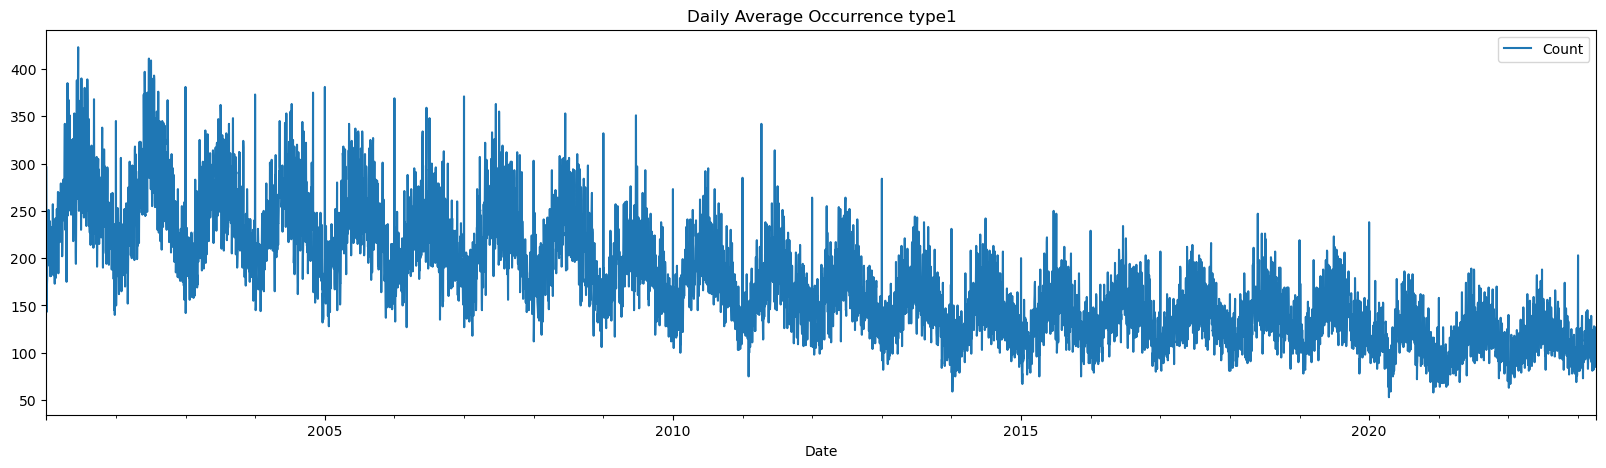

In [9]:
df_by_day.plot(figsize=fig_size, title="Daily Average Occurrence " + crime)
plt.show()

In [10]:
df_by_day[target].sort_values(ascending=False).head()

Date
2001-06-17    423
2002-06-23    411
2002-07-04    409
2002-06-01    397
2002-07-20    393
Name: Count, dtype: int64

### By week

In [11]:
df_by_week = pd.DataFrame(df_by_day[target].resample('W').mean())

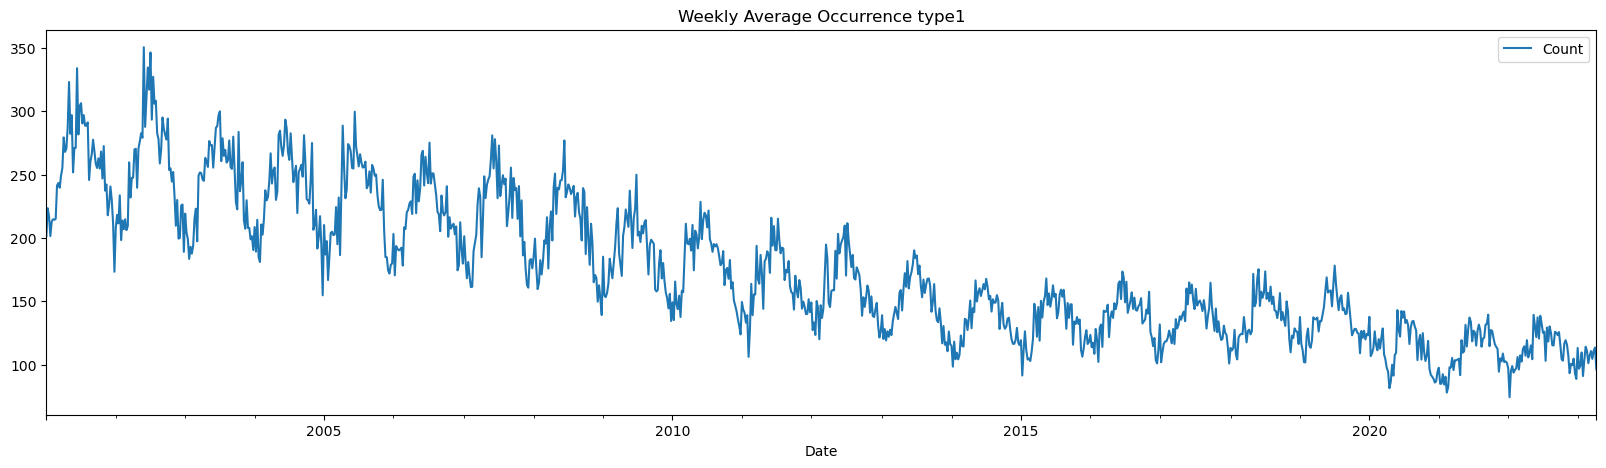

In [12]:
df_by_week.plot(
    figsize=fig_size,
    title="Weekly Average Occurrence " + crime)
plt.show()

### By month

In [13]:
df_by_month = pd.DataFrame(df_by_day[target].resample('M').mean())

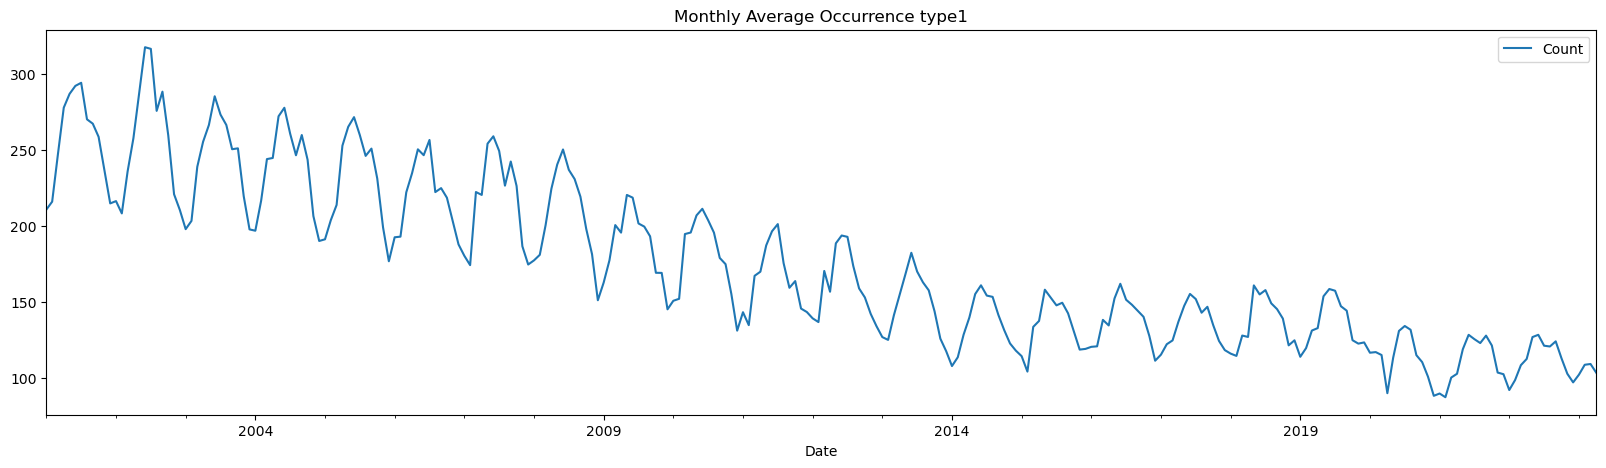

In [14]:
df_by_month.plot(
    figsize=fig_size, 
    title="Monthly Average Occurrence " + crime)
plt.show()

## Analysis

In [15]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(count):
    result=adfuller(count)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

### Checking stationary

In [16]:
adfuller_test(df_by_month[target])

ADF Test Statistic : -1.1257894251667415
p-value : 0.7046785869157075
#Lags Used : 14
Number of Observations Used : 253
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### Checking seasonality

In [17]:
df_by_month['seasonal_first_difference'] = df_by_month[target] - df_by_month[target].shift(12)

In [18]:
adfuller_test(df_by_month['seasonal_first_difference'].dropna())

ADF Test Statistic : -4.335873703851938
p-value : 0.0003847880016246871
#Lags Used : 12
Number of Observations Used : 243
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: title={'center': 'Seasonal difference plot - type1'}, xlabel='Date'>

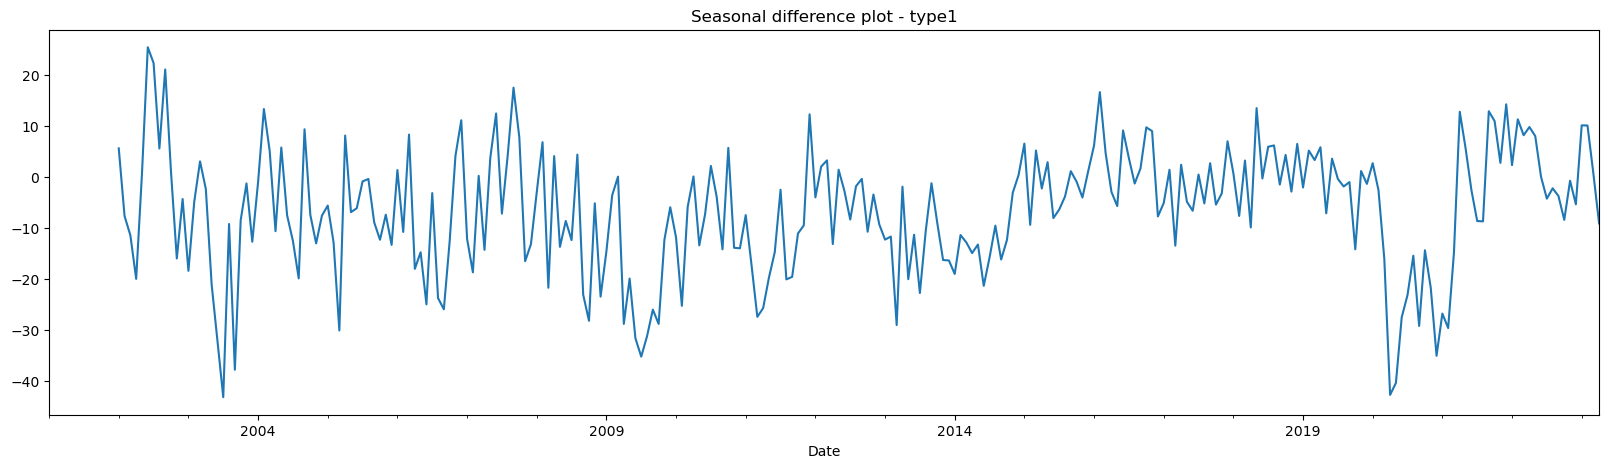

In [19]:
df_by_month['seasonal_first_difference'].plot(figsize=fig_size, title='Seasonal difference plot - ' + crime)

### Auto Regressive Model

/Users/xuyanchong/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


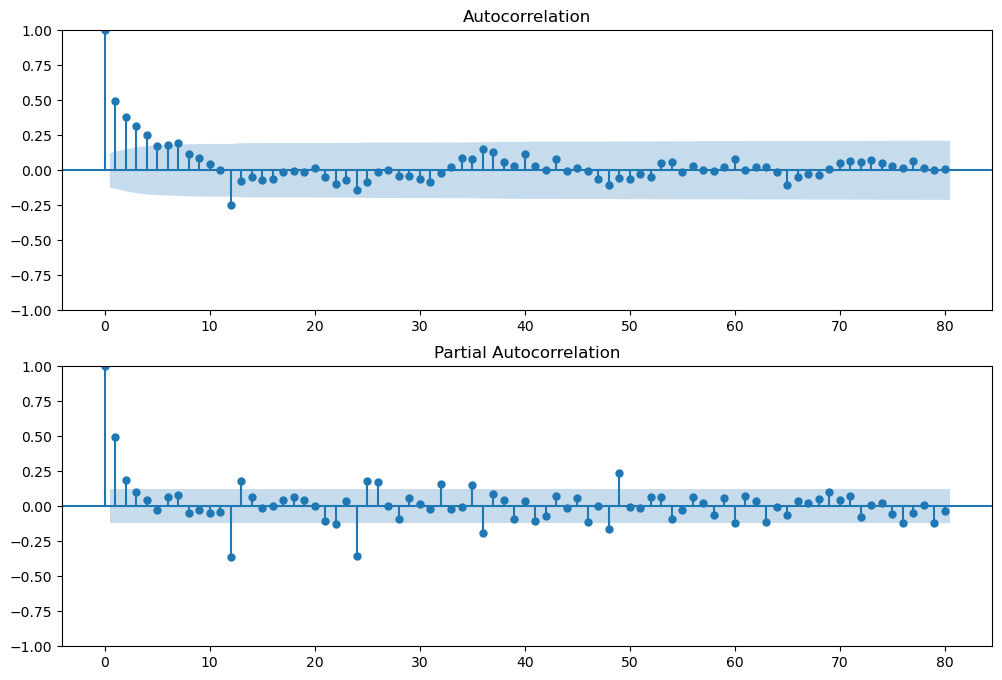

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_by_month['seasonal_first_difference'].iloc[13:],lags=80,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_by_month['seasonal_first_difference'].iloc[13:],lags=80,ax=ax2)

### Implementing Seasonal Arima Model

In [21]:
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(df_by_month[target])

(0.01, False)

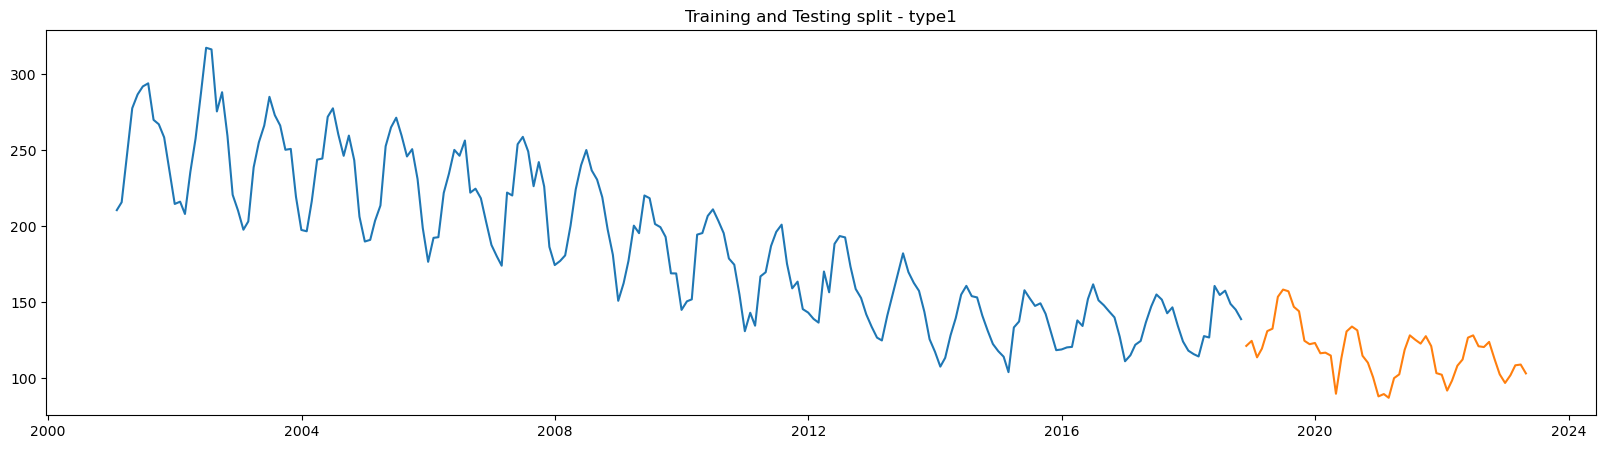

In [22]:
start=int(df_by_month.shape[0]*0.8)
train=df_by_month[:start]
test=df_by_month[start:]
plt.figure(figsize=fig_size)
plt.plot(train[target])
plt.plot(test[target])
plt.title('Training and Testing split - '+ crime)
plt.show()

In [23]:
model=auto_arima(train[target],start_p=0,d=1,start_q=0,
          max_p=10,max_d=10,max_q=10, start_P=0,
          D=1, start_Q=0, max_P=10,max_D=10,
          max_Q=10, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1599.851, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1521.442, Time=0.81 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1468.648, Time=3.16 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1533.339, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1470.446, Time=3.66 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1470.306, Time=22.09 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1494.488, Time=0.93 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=28.72 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1518.288, Time=1.57 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1464.449, Time=3.33 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1531.298, Time=0.54 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1466.355, Time=3.95 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1466.295, Time=25.90 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1493.450, Time=1.47 sec
 ARIMA(1,1,1)(1,1,2)[

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  214
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -728.224
Date:                            Sun, 23 Apr 2023   AIC                           1464.449
Time:                                    01:34:17   BIC                           1477.662
Sample:                                01-31-2001   HQIC                          1469.795
                                     - 10-31-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2699      0.097      2.788      0.005       0.080       0.460
ma.L1         -0.8472      0.052    -16.196      0.000      -0.950      -0.745
ma.S.L12      -0.6542      0.071     -9.177      0.000      -0.794      -0.515
sigma2        79.0241      8.944      8.835      0.000      61.494      96.554
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.77   Prob(JB):                         0.62
Heteroskedasticity (H):               0.41   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

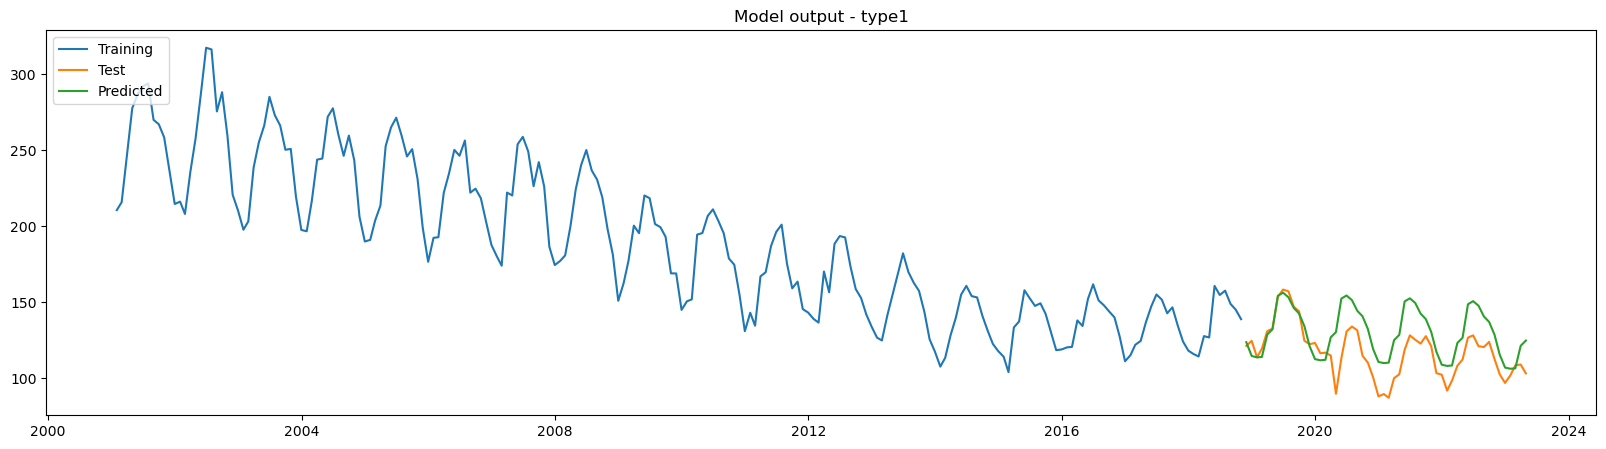

In [25]:
prediction = pd.DataFrame(model.predict(n_periods = train.shape[0]),index=test.index)
prediction.columns = ['predicted_crime']
plt.figure(figsize=fig_size)
plt.plot(train[target],label="Training")
plt.plot(test[target],label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.savefig('../output/%s_%s_pred.jpg' % (city,crime))
plt.title('Model output - '+crime)
plt.show()

In [26]:
np.sqrt(np.square(np.subtract(test[target].values,prediction['predicted_crime'].values)).mean())

17.381555810118396